### Example EcoPlate Analysis

This notebook assumes that you have already run the example analysis as described in the README. You will see that the "pcaBy_specimen.png" image shows a clear separation between the larval and water samples. As such, we may want to recluster the data using those parameters separately.

First, we import the necessary modules and the integration data from the original analysis.

In [1]:
# Standard data handling packages
import pandas as pd
import numpy as np

# Plotting packages for custom plots
import matplotlib.pyplot as plt
import seaborn as sns
import math

# The analysis scripts packaged in this repo
import ecoplate_analysis
import ecoplate_dataviz

int_df = pd.read_csv('defaultOutput/waterLarvaeIntegration.csv')

int_df.head()

,metab,sample,trapezoid_integration
0,Glycogen,25D_L_3,47.076
1,β-Methyl-D-Glucoside,25E_L_2,20.904
2,D-Xylose,25D_W_2,0.216
3,Pyruvic Acid Methyl Ester,ND_W_2,13.218
4,Pyruvic Acid Methyl Ester,4_L_1,12.724


We're next going to split this dataframe into separate water and larval dataframes:

In [2]:
w_df = int_df[int_df['sample'].str.contains('_W_')].copy()
L_df = int_df[int_df['sample'].str.contains('_L_')].copy()

w_df.head()

,metab,sample,trapezoid_integration
2,D-Xylose,25D_W_2,0.216
3,Pyruvic Acid Methyl Ester,ND_W_2,13.218
6,L-Threonine,25D_W_1,10.762
9,D-Glucosaminic Acid,ND_W_3,1.044
10,Glycogen,ND_W_2,60.604


Now that we have the data separated as desire, we'll perform independent PCAs on each dataframe:

In [3]:
wpca_df, wpca, wloadings = ecoplate_analysis.metabolite_pca(w_df)
Lpca_df, Lpca, Lloadings = ecoplate_analysis.metabolite_pca(L_df)

print(f'Water Explained Variance: {wpca.explained_variance_ratio_}')
print(f'Larvae Explained Variance: {Lpca.explained_variance_ratio_}')

Water Explained Variance: [0.32497575 0.17118614]
Larvae Explained Variance: [0.34366299 0.20790952]


We can now see that the water and larvae samples have different degrees of variance explained by the principal components. Let's use the dataviz functions to revisualize. We first need to reshape the dataframe a bit:

In [4]:
sample_info = ['diapause','specimen','rep']

for i,v in enumerate(sample_info):
    Lpca_df[v] = [j.split('_')[i] for j in Lpca_df['sample']]

Lpca_df.head()

,sample,PC1,PC2,diapause,specimen,rep
0,25D_L_1,-3.551541,-1.331140,25D,L,1
1,25D_L_2,1.820498,-1.094964,25D,L,2
2,25D_L_3,-1.177460,-0.143880,25D,L,3
3,25E_L_1,-4.967901,2.643524,25E,L,1
4,25E_L_2,-0.683665,0.196436,25E,L,2


We now have all the columns necessary for coloring the data by diapause condition:

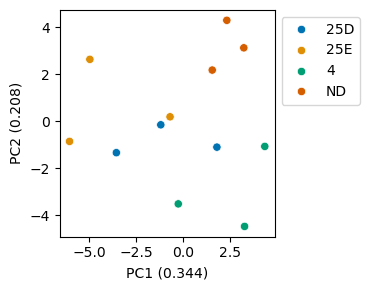

PCA plot saved to dataViz/


In [5]:
# Round the explained variance to make labels nicer
evar = [round(i,3) for i in Lpca.explained_variance_ratio_]

# Plot
ecoplate_dataviz.plot_pca(Lpca_df,
                          evar,
                          'dataViz',
                          'diapause',
                          cmap='colorblind',
                          show_cbar=False,
                          show_plot=True)

From this we can see that the 4°C and non-diapausing conditions cluster relatively well on PC1, but are separated on PC2. We can look at the contribution of each metabolite to each PC to see if this correlates with a specific metabolite.

On PC1, both conditions are high, so we can sort in descending order to see the metabolites that push samples to the right on PC1:

In [6]:
Lloadings.sort_values('PC1', ascending=False).iloc[:6]

,PC1,PC2
metab,,
L-Arginine,0.262,0.011
γ-Amino Butyric Acid,0.250,0.043
Itaconic Acid,0.248,0.099
D-Galactonic Acid γ-Lactone,0.247,-0.187
β-Methyl-D-Glucoside,0.230,0.190
Glucose-1-Phosphate,0.228,0.167


None of these metabolites stand out particularly, but let's take a look at the curves. To do this, we'll import the tidy dataframe containing all of the EcoPlate data and plot just the metabolites we're interested in.

In [7]:
# Import the tidy dataframe and check that it looks as expected
tidy_df = pd.read_csv('defaultOutput/waterLarvaeTidy.csv')
tidy_df.head()

,Well,590,metab,timepoint,sample,diapause,specimen,rep,blanked_590,hours
0,A1,0.310,Water,24h,4_L_1,4,L,1,0.0,24
1,A5,0.271,Water,24h,4_L_1,4,L,1,0.0,24
2,A9,0.334,Water,24h,4_L_1,4,L,1,0.0,24
3,A2,0.206,β-Methyl-D-Glucoside,24h,4_L_1,4,L,1,0.0,24
4,A6,0.221,β-Methyl-D-Glucoside,24h,4_L_1,4,L,1,0.0,24


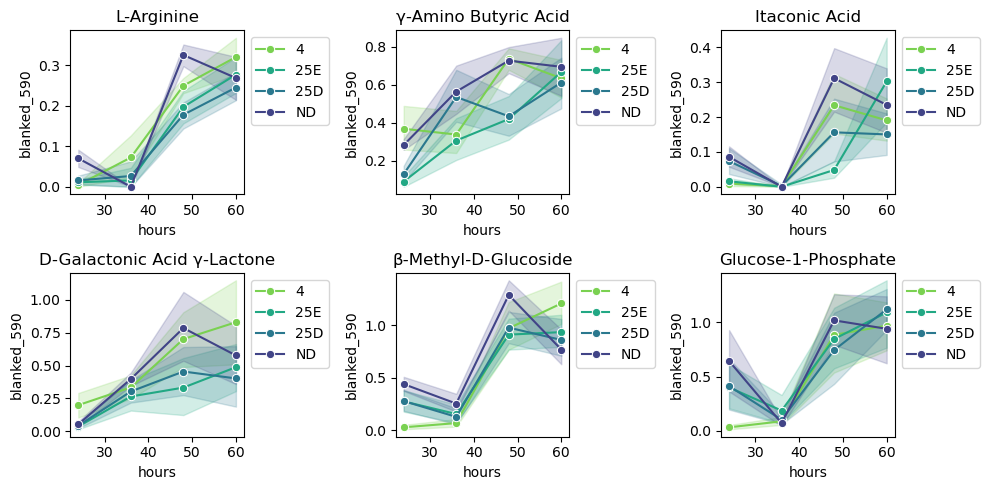

In [8]:
# Extract the metabolites we want to visualize
top_pc1 = Lloadings.sort_values('PC1', ascending=False).iloc[:6].index

# Use seaborn and matplotlib to display
ax_v = 2
ax_h = 3
fig, ax = plt.subplots(ax_v,ax_h,figsize=(10,5))

for i,v in enumerate(top_pc1):
    subdf = tidy_df[tidy_df['metab'] == v]
    x  = math.trunc(i / 3)
    y = int(i - 3*x)
    sns.lineplot(data=subdf,
                x='hours',
                y='blanked_590',
                hue='diapause',
                palette='viridis_r',
                marker='o',
                legend=True,
                ax=ax[x,y])
    ax[x,y].set_title(v)
    ax[x,y].legend(bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()

PCA is performed on the integrated intensity over time, and it seems that for the top four hits 4°C and non-diapausing may have had slightly higher integration values than the other diapause conditions. None of these differences are terribly dramatic, but they do likely explain the tightness of 4°C and non-diapausing on PC1. 

Because they differ on PC2, we'll want to look at the highest absolute values of PC2 (rather than the raw values) to see what might be splitting the samples on that axis.

In [9]:
Lloadings['absPC2'] = np.abs(Lloadings['PC2'])

Lloadings.sort_values('absPC2', ascending=False).iloc[:6]

,PC1,PC2,absPC2
metab,,,
Tween 80,-0.047,0.333,0.333
L-Serine,0.165,0.302,0.302
Glycogen,-0.030,0.284,0.284
N-Acetyl-D-Glucosamine,0.093,0.269,0.269
Tween 40,-0.107,0.263,0.263
D-Cellobiose,0.192,-0.254,0.254


Here, Tween 40 positively contributes to PC2, while D-Cellobiose contributes negatively. We can see whether this explains the separation of 4°C and non-diapausing using essentially the same code as before.

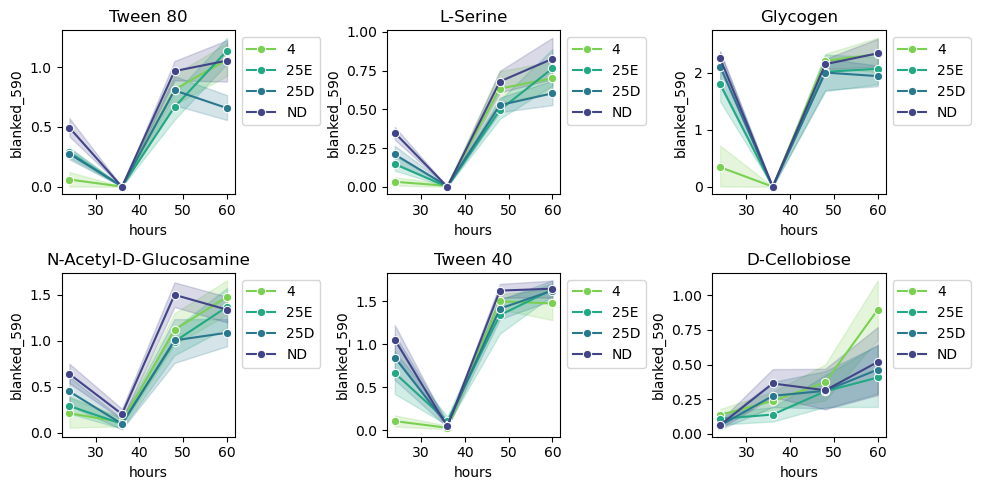

In [10]:
# Extract the metabolites we want to visualize
top_pc2 = Lloadings.sort_values('absPC2', ascending=False).iloc[:6].index

# Use seaborn and matplotlib to display
ax_v = 2
ax_h = 3
fig, ax = plt.subplots(ax_v,ax_h,figsize=(10,5))

for i,v in enumerate(top_pc2):
    subdf = tidy_df[tidy_df['metab'] == v]
    x  = math.trunc(i / 3)
    y = int(i - 3*x)
    sns.lineplot(data=subdf,
                x='hours',
                y='blanked_590',
                hue='diapause',
                palette='viridis_r',
                marker='o',
                legend=True,
                ax=ax[x,y])
    ax[x,y].set_title(v)
    ax[x,y].legend(bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()

The biggest difference visible here is that 4°C consistently has lower 24h values for the top five metabolites. 

To save any of these plots, insert the following code between `plt.tight_layout()` and `plt.show()` in any of the above cells:

`plt.savefig('dataViz/yourFileName.png', fmt='png', dpi=300)`

***

In [12]:
%load_ext watermark
%watermark -v -p pandas,numpy,matplotlib,seaborn,jupyterlab

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.11.13
IPython version      : 9.4.0

pandas    : 2.3.1
numpy     : 1.26.4
matplotlib: 3.10.5
seaborn   : 0.13.2
jupyterlab: 4.4.5

